In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [4]:
class AudioDataset(Dataset):
    def __init__(self, mfcc_features, labels):
        self.features = torch.FloatTensor(mfcc_features)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class Simple1DCNN(nn.Module):
    def __init__(self, input_features=40, input_length=150):
        super(Simple1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_features, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        # Calculate size after first Conv and Pool
        self.size_after_conv1 = (input_length + 2*1 - 3) // 1 + 1
        self.size_after_pool1 = (self.size_after_conv1 - 2) // 2 + 1

        self.flatten = nn.Flatten()
        # Adjust the linear layer size
        self.fc = nn.Linear(64 * self.size_after_pool1, 2)

    def forward(self, x):
        x = self.pool1(nn.ReLU()(self.conv1(x)))
        x = self.flatten(x)
        x = self.fc(x)
        return x

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_acc, val_acc = [], []
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for data in train_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_acc.append(correct / total)

        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_acc.append(correct / total)

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Train Acc: {train_acc[-1]*100:.2f}% - Val Loss: {val_losses[-1]:.4f} - Val Acc: {val_acc[-1]*100:.2f}%')

    return model, train_acc, val_acc, train_losses, val_losses


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('datasets/DAIC-WOZ/Patient_Classes.csv')

def plot_results(train_acc, val_acc, train_losses, val_losses):
    epochs = range(1, len(train_acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'go-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, 'g--', label='Training Loss')
    plt.plot(epochs, val_losses, 'r--', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def segment_mfcc(mfcc, max_segment_length=200):
    # Segment the MFCC array into fixed lengths with possible overlap (if desired)
    # segment_length is the fixed length of each segment
    segments = []
    for start in range(0, mfcc.shape[1], max_segment_length):
        end = start + max_segment_length
        if end < mfcc.shape[1]:
            segments.append(mfcc[:, start:end])
        else:
            # Padding the last segment if it's shorter than the required segment length
            segments.append(np.pad(mfcc[:, start:], ((0,0), (0, max_segment_length - (mfcc.shape[1] - start))), 'constant'))
    return segments

def load_concatenated_mfcc(path):
    
    # Load the concatenated MFCC data
    data = np.load(path)
    return data['mfcc']

def create_datasets(df, max_segment_length=500):
    dataset = {'train': [], 'test': []}
    labels = {'train': [], 'test': []}

    for _, row in df.iterrows():
        patient_id = row['Participant_ID']
        label = row['PHQ8_Binary']
        print(patient_id, label)
        train_or_test = row['dataset']  # Could be 'train' or 'test'
        # if train_or_test is 'dev' change it to 'test'
        if train_or_test == 'dev':
            train_or_test = 'test'

        mfcc_path = f'datasets/DAIC-WOZ/ConcatenatedMFCC/concatenated_mfcc_{patient_id}.npz'

        try:
            mfcc = load_concatenated_mfcc(mfcc_path)  # Load the raw MFCC data
            segments = segment_mfcc(mfcc, max_segment_length=max_segment_length)
            
            # Append each segment to the corresponding dataset
            for segment in segments:
                dataset[train_or_test].append(segment)
                labels[train_or_test].append(label)
        except Exception as e:
            print(f"Failed to process patient {patient_id}: {e}")

    return dataset, labels


MAX_SEGMENT_LENGTH = 3000
dataset, labels = create_datasets(df, max_segment_length=MAX_SEGMENT_LENGTH)

303 0
304 0
305 0
310 0
312 0
313 0
315 0
316 0
317 0
318 0
319 1
320 1
321 1
322 0
324 0
325 1
326 0
327 0
328 0
330 1
333 0
336 0
338 1
339 1
340 0
341 0
343 0
344 1
345 1
347 1
348 1
350 1
351 1
352 1
353 1
355 1
356 1
357 0
358 0
360 0
362 1
363 0
364 0
366 0
368 0
369 0
370 0
371 0
372 1
374 0
375 0
376 1
379 0
380 1
383 0
385 0
386 1
391 0
392 0
393 0
397 0
400 0
401 0
402 1
409 0
412 1
414 1
415 0
416 0
419 0
423 0
425 0
426 1
427 0
428 0
429 0
430 0
433 1
434 0
437 0
441 1
443 0
444 0
445 0
446 0
447 0
448 1
449 0
454 0
455 0
456 0
457 0
459 1
463 0
464 0
468 0
471 0
473 0
474 0
475 0
478 0
479 0
485 0
486 0
487 0
488 0
491 0
Failed to process patient 491: [Errno 2] No such file or directory: 'datasets/DAIC-WOZ/ConcatenatedMFCC/concatenated_mfcc_491.npz'
302 0
307 0
331 0
335 1
346 1
367 1
377 1
381 1
382 0
388 1
389 1
390 0
395 0
403 0
404 0
406 0
413 1
417 0
418 1
420 0
422 1
436 0
439 0
440 1
451 0
458 0
472 0
476 0
477 0
482 0
483 1
484 0
489 0
Failed to process patient 489

In [6]:
dataset_train = AudioDataset(dataset["train"], labels["test"])
dataset_val = AudioDataset(dataset["test"], labels["test"])

C:\Users\Gergo Gyori\AppData\Local\Temp\ipykernel_5648\2726794641.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  self.features = torch.FloatTensor(mfcc_features)


In [7]:
loader_train = DataLoader(dataset_train, batch_size=2, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=2, shuffle=False)

Epoch 1/50 - Train Loss: 249.8205 - Train Acc: 53.90% - Val Loss: 44.9644 - Val Acc: 52.42%
Epoch 2/50 - Train Loss: 6.4019 - Train Acc: 79.55% - Val Loss: 20.2574 - Val Acc: 56.88%
Epoch 3/50 - Train Loss: 1.2312 - Train Acc: 91.08% - Val Loss: 9.5197 - Val Acc: 59.85%
Epoch 4/50 - Train Loss: 0.4586 - Train Acc: 96.28% - Val Loss: 8.3424 - Val Acc: 61.71%
Epoch 5/50 - Train Loss: 0.1084 - Train Acc: 98.88% - Val Loss: 9.7223 - Val Acc: 61.34%
Epoch 6/50 - Train Loss: 0.0005 - Train Acc: 100.00% - Val Loss: 10.1435 - Val Acc: 61.71%
Epoch 7/50 - Train Loss: 0.0000 - Train Acc: 100.00% - Val Loss: 10.1593 - Val Acc: 61.71%
Epoch 8/50 - Train Loss: 0.0000 - Train Acc: 100.00% - Val Loss: 10.1704 - Val Acc: 61.34%
Epoch 9/50 - Train Loss: 0.0000 - Train Acc: 100.00% - Val Loss: 10.1791 - Val Acc: 61.34%
Epoch 10/50 - Train Loss: 0.0000 - Train Acc: 100.00% - Val Loss: 10.1894 - Val Acc: 61.34%
Epoch 11/50 - Train Loss: 0.0000 - Train Acc: 100.00% - Val Loss: 10.1982 - Val Acc: 61.34%
Epo

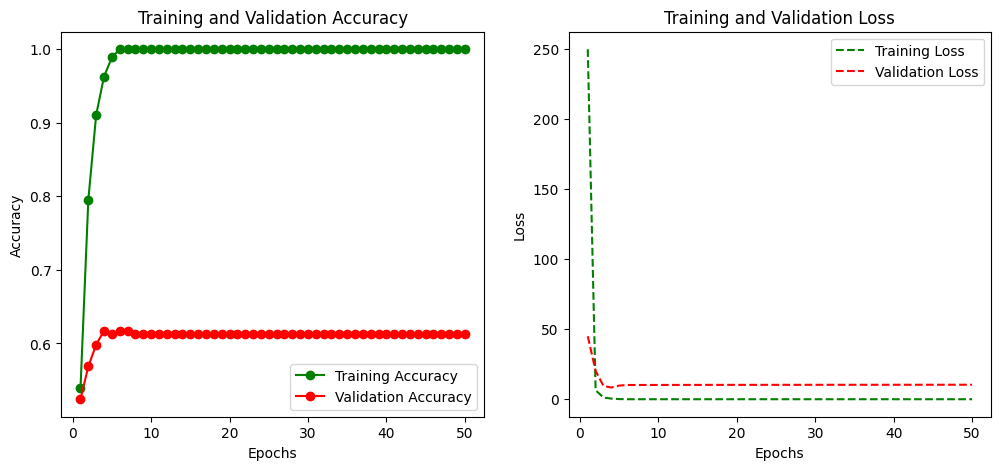

In [8]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Simple1DCNN(input_length=MAX_SEGMENT_LENGTH).to(device)
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
model, train_acc, val_acc, train_losses, val_losses = train_model(model, loader_train, loader_val, num_epochs=50, learning_rate=0.001)
plot_results(train_acc, val_acc, train_losses, val_losses)

### Random dummy for development purposes

Epoch 1/50 - Train Loss: 0.5508 - Train Acc: 80.00% - Val Loss: 0.1929 - Val Acc: 95.00%
Epoch 2/50 - Train Loss: 0.1733 - Train Acc: 95.00% - Val Loss: 0.0757 - Val Acc: 100.00%
Epoch 3/50 - Train Loss: 0.0545 - Train Acc: 100.00% - Val Loss: 0.0335 - Val Acc: 100.00%
Epoch 4/50 - Train Loss: 0.0288 - Train Acc: 100.00% - Val Loss: 0.0226 - Val Acc: 100.00%
Epoch 5/50 - Train Loss: 0.0194 - Train Acc: 100.00% - Val Loss: 0.0158 - Val Acc: 100.00%
Epoch 6/50 - Train Loss: 0.0143 - Train Acc: 100.00% - Val Loss: 0.0121 - Val Acc: 100.00%
Epoch 7/50 - Train Loss: 0.0114 - Train Acc: 100.00% - Val Loss: 0.0100 - Val Acc: 100.00%
Epoch 8/50 - Train Loss: 0.0095 - Train Acc: 100.00% - Val Loss: 0.0085 - Val Acc: 100.00%
Epoch 9/50 - Train Loss: 0.0081 - Train Acc: 100.00% - Val Loss: 0.0073 - Val Acc: 100.00%
Epoch 10/50 - Train Loss: 0.0070 - Train Acc: 100.00% - Val Loss: 0.0064 - Val Acc: 100.00%
Epoch 11/50 - Train Loss: 0.0062 - Train Acc: 100.00% - Val Loss: 0.0057 - Val Acc: 100.00%


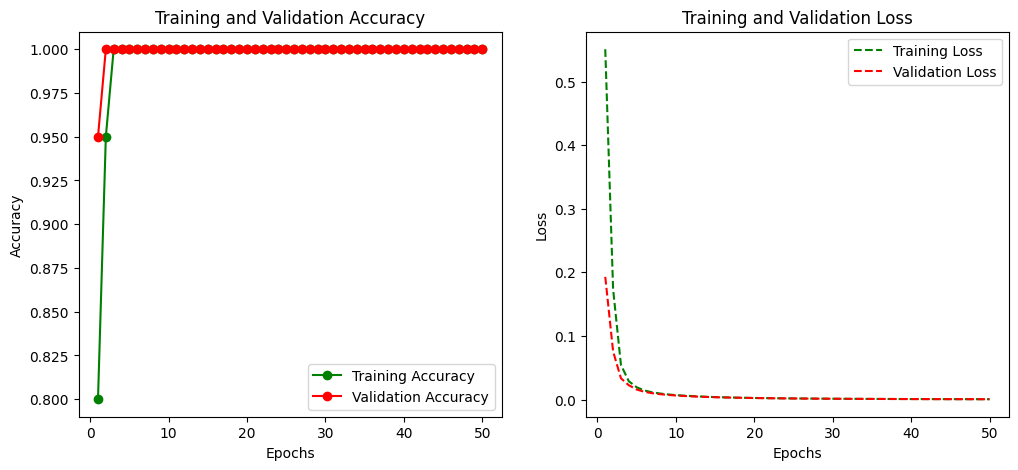

In [11]:
    # Dummy data (10 samples, 40 MFCC features, varying length of 150)
PARTICIPANTS = 20 # automatically has to be defined 
MFCC_LENGTH = 50 # I have to control the numbeer of MFCC features (so like cutting or whatever)

mfcc_features = np.random.randn(PARTICIPANTS, 40, MFCC_LENGTH) # 10 pcs of 40 MFCC features with length of 150
# (200, 40, 500) 
labels = np.random.randint(0, 2, size=(PARTICIPANTS,)) # so the labels 0 2 means labels between 0 and 1

dataset = AudioDataset(mfcc_features, labels)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Simple1DCNN(input_length=MFCC_LENGTH).to(device)
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
model, train_acc, val_acc, train_losses, val_losses = train_model(model, loader, loader, num_epochs=50, learning_rate=0.001)
plot_results(train_acc, val_acc, train_losses, val_losses)

In [2]:
import torch

# Basic check if CUDA is available
is_cuda = torch.cuda.is_available()
print(f"CUDA available: {is_cuda}")

# If you want more details:
if is_cuda:
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name()}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

CUDA available: True
Current CUDA device: 0
Device name: NVIDIA GeForce GTX 1650 Ti
Number of GPUs: 1


In [1]:
import torch
print(torch.__version__)
print(torch.version.cuda) 

2.3.1+cu118
11.8
